In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import model
import dataset
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [2]:
#Set device
#if cuda is available then use cuda, else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#declare parameters

input_size = 32*32 #image size = 32x32 --flatten 1024
n_classes = 10
n_epoch = 1
batch_size = 100
learning_rate = 0.001

In [4]:
#Make dataset with transform included

composed_transform = transforms.Compose([transforms.ToTensor(),
                     transforms.Normalize(mean = (0.5, 0.5, 0.5 ), std = (0.5, 0.5, 0.5))])

train_dataset = dataset.TrainSet(transform = composed_transform)
test_dataset = dataset.TestSet(transform = composed_transform)

#Make dataloader
#Note: DataLoader antomatically transform data from numpy to tensor
#But we still do ToTensor transform to Normalize(normalize require tensor dtype)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 16, shuffle = False)

In [5]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

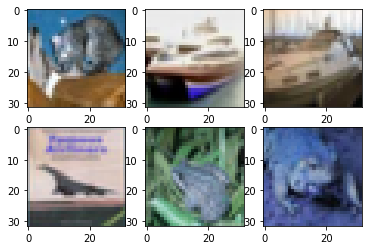

In [6]:
#Show some examples to examinate dataloader

examples = iter(test_loader)
example_images, example_labels = examples.next()

#because imshow only accept h w c image
#while training using c h w mode (for RGB mode, gray mode don't have to be transposed)
#we trapnspouse the matrix then denormalize for imshow
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.transpose(example_images[i]/2+0.5, (1, 2, 0)))
plt.show()

In [7]:
model = model.CNN().to(device)
print(model)

CNN(
  (Conv): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU): ReLU()
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Linear): Linear(in_features=2560, out_features=10, bias=True)
)


In [8]:
#Define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [9]:
#Make Training Loop

steps = len(train_loader)

print('Start training...')

for epoch in range(n_epoch):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        #Note: Labels are now dtype torch.uint8, should be change to torch.long for CrossEntropyLoss
        labels = labels.type(torch.long)
        labels = labels.to(device)
        #forward pass
        pred_labels = model(images)
        loss = criterion(pred_labels, labels)

        #backward pass
        loss.backward()

        #update gradients
        optimizer.step()
        optimizer.zero_grad()

        #print information in a epoch
        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1}/{n_epoch}, step: {(i+1)}/{steps}, loss: {loss.item():.3f}')

            
print('Training is completed')

Start training...
epoch: 1/1, step: 100/500, loss: 1.572
epoch: 1/1, step: 200/500, loss: 1.593
epoch: 1/1, step: 300/500, loss: 1.333
epoch: 1/1, step: 400/500, loss: 1.536
epoch: 1/1, step: 500/500, loss: 1.279
Training is completed


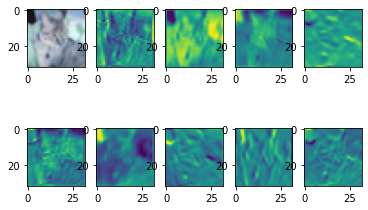

In [10]:
#show the feature map

#evaluation mode
model.eval()
img = test_dataset[8][0]
imgplot = np.transpose(img, (1, 2, 0))
#add one dimention for model input
img = img[None, :, :, :]
img = torch.FloatTensor(img).to(device)
feature_map = model.featuremap(img).detach().cpu()

plt.subplot(2, 5, 1)
#denormalize
plt.imshow(imgplot/2+0.5)

for i in range(9):
    plt.subplot(2,5,i+2)
    plt.imshow(feature_map[0, i, :, :])
plt.show()

model accuracy: 0.520


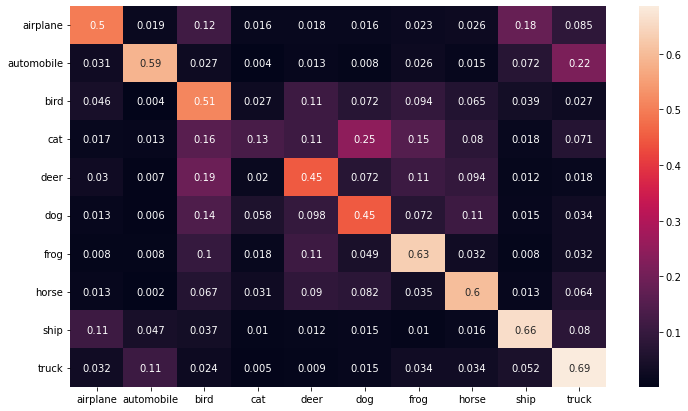

In [11]:
#Test the model
#Also make the confution matrix

#Note: In test case, we do not want to calculate the gradients
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    #save predictoins and tragets in linespace to make a confution matrix
    cf_pred = []
    cf_actual = []
    #you can also use for i, (images, labels) in enumerate(test_loader):
    #but now we don't care batch imformation, simple use this
    for images, labels in test_loader:
        #flatten
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        #the output is a probability distribution. We want to tranform them into integer(predicted state)
        #torch.max(tensor, dimention) will return [max tensor value, index] in a dimention of a tensor
        #here we only want the index, not the linear output(float), actually it is the predicted number
        #Note: _ here is not probability because we didn't apply softmax
        _, predicted = torch.max(output, 1)
        #transform from tensor to numpy
        predicted = predicted.cpu().numpy()
        cf_pred.extend(predicted)
        labels = labels.cpu().numpy()
        cf_actual.extend(labels)

        n_samples = n_samples + labels.shape[0]
        #Note (predicted == labels) is still a tensor with one element. We need to use item() to get a value
        #then we can compute divition
        n_correct = n_correct + (predicted == labels).sum().item()

acc = n_correct / n_samples
print(f'model accuracy: {acc:.3f}')

#make confution matrix

#confution_matrix form a 2d array from two seperate 1d array
cf_matrix = confusion_matrix(cf_actual, cf_pred)
#include dataframe showing classes of prediction
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix, axis = 1), index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12, 7))
sn.heatmap(df_cm, annot = True)
plt.show()


In [12]:
#See some predictions of the model

with torch.no_grad():
    examples = iter(test_loader)
    data, actual_labels = examples.next()
    data = data.to(device)
    predicted_labels = model(data)
    _, predicted_labels = torch.max(predicted_labels, 1)

print('predicted labels:\n', predicted_labels.cpu().numpy())
print('actual labels:\n', actual_labels.numpy().squeeze())



predicted labels:
 [3 1 8 8 4 6 1 6 3 1 8 9 6 7 9 8]
actual labels:
 [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8]
